In [ ]:
# Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import random
import time
import copy
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from custom_torch_dataset_organ import SegDataset
from eval_functions import *
from transforms import *
import cv2



In [ ]:
# Load dataset
train_data_dir = "/content/drive/MyDrive/BioimageProjData/training/image"
train_annot_path = '/content/drive/MyDrive/BioimageProjData/train_70-30.csv'
test_data_dir = "/content/drive/MyDrive/BioimageProjData/training/image"
test_annot_path = '/content/drive/MyDrive/BioimageProjData/test_70-30.csv'

In [ ]:
data_transforms = {
    'train': Compose([
    ToTensor(),
    Resize(256),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': Compose([
    ToTensor(),
    Resize(256),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
}


In [ ]:
num_workers = 2
batch_size = 8

# Create training and validation datasets
image_datasets = {'train': SegDataset(root_dir=train_data_dir,annot_csv=train_annot_path,transform=data_transforms['train'], tissue='largeintestine'),
                  'val': SegDataset(root_dir=test_data_dir,annot_csv=test_annot_path,transform=data_transforms['val'], tissue='largeintestine'),
}
# image_datasets = {'train': SegDataset(root_dir=train_data_dir,annot_csv=train_annot_path,transform=data_transforms['train']),
#                   'val': SegDataset(root_dir=test_data_dir,annot_csv=test_annot_path,transform=data_transforms['val']),
# }

In [ ]:
data_aug_1 = Compose([RandomHorizontalFlip(1)])
data_aug_2 = Compose([RandomVerticalFlip(1)])
data_aug_3 = Compose([RandomRotation()])
data_aug_4 = Compose([ShearX()])
data_aug_5 = Compose([ShearY()])
data_aug_6 = Compose([RandomHorizontalFlip(1), RandomVerticalFlip(1)])
data_aug_7 = Compose([RandomHorizontalFlip(1),RandomRotation()])
data_aug_7 = Compose([RandomVerticalFlip(1),RandomRotation()])
data_aug_8 = Compose([RandomRotation(), ShearX()])
data_aug_9 = Compose([ShearX(),ShearY()])
data_aug_10 = Compose([RandomVerticalFlip(1),ShearX()])
data_augs = [data_aug_1, data_aug_2, data_aug_3, data_aug_4, data_aug_5, data_aug_6, data_aug_7, data_aug_8, data_aug_9, data_aug_10]

In [ ]:
train_augs = [image_datasets['train']]
for aug in data_augs:
  train_aug = SegDataset(root_dir=train_data_dir,annot_csv=train_annot_path,transform=data_transforms['train'], tissue='largeintestine', augment=aug)
  # train_aug = SegDataset(root_dir=train_data_dir,annot_csv=train_annot_path,transform=data_transforms['train'], augment=aug)
  train_augs.append(train_aug)

In [ ]:
train_and_aug_sets = torch.utils.data.ConcatDataset(train_augs)
# Create training and validation dataloaders
dataloaders_dict = {'train': torch.utils.data.DataLoader(train_and_aug_sets, batch_size=batch_size, 
                    shuffle=True, num_workers=num_workers),
                    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=batch_size, 
                    shuffle=True, num_workers=num_workers),
}

In [ ]:
class DiceLoss():
  def __init__(self, weight=None, size_average=True):
      super(DiceLoss, self).__init__()
  def __call__(self, pred, y):
    pred = pred.float()
    y = y.float()
    
    intersection = (pred * y).sum(dim = 3).sum(dim=2).sum(dim=1)                           
    dice = (2.*intersection + 1)/(pred.sum(dim = 3).sum(dim=2).sum(dim=1) + y.sum(dim = 3).sum(dim=2).sum(dim=1) + 1)
    return dice.sum()

In [ ]:
def dice_loss(pred, y):
    pred = pred.float()
    y = y.float()
    
    intersection = (pred * y).sum(dim = 3).sum(dim=2).sum(dim=1)                           
    dice = (2.*intersection + 1)/(pred.sum(dim = 3).sum(dim=2).sum(dim=1) + y.sum(dim = 3).sum(dim=2).sum(dim=1) + 1)
    return dice.sum()

def my_dice(pred, y, th):
    pred = pred.cpu().detach().numpy()
    pred = (pred>th).squeeze()
    try:
      pred.shape[2]
    except IndexError:
      pred = pred.reshape((1,pred.shape[0],pred.shape[1]))
    pred_2 = np.dstack((pred.reshape(-1), (1-pred).reshape(-1))).reshape((pred.shape[0],pred.shape[1],pred.shape[2],2))
    y = y.cpu().detach().numpy().squeeze()
    try:
      y.shape[2]
    except IndexError:
      y = y.reshape((1,y.shape[0],y.shape[1]))
    y_2 = np.dstack((y.reshape(-1), (1-y).reshape(-1))).reshape((y.shape[0],y.shape[1],y.shape[2],2))
    intersect_2 = np.logical_and(pred_2 == 1, y_2 == 1).sum(2).sum(1) * 2
    total_pixel = (pred_2 < 2).sum(2).sum(1) + (y_2 < 2).sum(2).sum(1)
    dice = np.mean(intersect_2 / total_pixel, -1)
    return dice.sum()

def train_model(model, dataloaders, criterion, optimizer, device, num_epochs=25, is_inception=False):
    since = time.time()

    train_loss_history = []
    val_loss_history = []
    val_dice_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    # best_loss = float('inf')
    best_loss = 0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)
        e_start = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0
            running_dice_loss = 0
            # running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs.float(), labels.float())
                        loss2 = criterion(aux_outputs.float(), labels.float())
                        loss = loss1 + 0.4*loss2
                    else:
                        # print(f'Intput size: {inputs.size()}')
                        outputs = model(inputs) #['out'][:,1,:,:].unsqueeze(1) #.argmax(1).unsqueeze(1)
                        # print(f'Output size, label size: {outputs.size()} , {labels.size()}')
                        loss = criterion(outputs.float(), labels.float())
                        d_loss = my_dice(outputs, labels, 0.5)
                        running_dice_loss += d_loss

                    # _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        # for param in model.parameters():
                        #     param.retain_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item()# * inputs.size(0)
                
                # running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_dice_loss = running_dice_loss/ len(dataloaders[phase].dataset)
            # epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)


            # deep copy the model
            # if phase == 'val' and epoch_loss < best_loss:
            if phase == 'val' and epoch_loss > best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss_history.append(epoch_loss)
                val_dice_loss_history.append(epoch_dice_loss)
            else:
                train_loss_history.append(epoch_loss)

        e_elapsed = time.time() - e_start
        print(f'Epoch {epoch+1} took {e_elapsed // 60}m {e_elapsed % 60}s')
        print('epoch loss:', epoch_loss)
        print('epoch dice loss:', epoch_dice_loss)

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss_history, val_loss_history, val_dice_loss_history


In [ ]:
class Unet(nn.Module):
    def __init__(self, n_filter=32):
        """
        Neural network for semantic image segmentation U-Net (PyTorch),
        Reference:  Falk, T. et al. U-Net: deep learning for cell counting, detection, and morphometry. Nat Methods 16,
        67–70 (2019).
        Parameters
        ----------
        n_filter : int
            Number of convolutional filters (commonly 16, 32, or 64)
        """
        super().__init__()
        # encode
        self.encode1 = self.conv(3, n_filter, dropout=0.5)
        self.encode2 = self.conv(n_filter, n_filter)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encode3 = self.conv(n_filter, 2 * n_filter)
        self.encode4 = self.conv(2 * n_filter, 2 * n_filter)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encode5 = self.conv(2 * n_filter, 4 * n_filter)
        self.encode6 = self.conv(4 * n_filter, 4 * n_filter)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encode7 = self.conv(4 * n_filter, 8 * n_filter)
        self.encode8 = self.conv(8 * n_filter, 8 * n_filter)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encode9 = self.conv(8 * n_filter, 16 * n_filter)
        self.encode10 = self.conv(16 * n_filter, 16 * n_filter)
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # middle
        self.middle_conv1 = self.conv(16 * n_filter, 32 * n_filter)
        self.middle_conv2 = self.conv(32 * n_filter, 32 * n_filter, dropout=0.5)

        # decode
        self.up0 = nn.ConvTranspose2d(32 * n_filter, 16 * n_filter, kernel_size=2, stride=2)
        self.decode0 = self.conv(32 * n_filter, 16 * n_filter)
        self.decode00 = self.conv(16 * n_filter, 16 * n_filter)
        self.up1 = nn.ConvTranspose2d(16 * n_filter, 8 * n_filter, kernel_size=2, stride=2)
        self.decode1 = self.conv(16 * n_filter, 8 * n_filter)
        self.decode2 = self.conv(8 * n_filter, 8 * n_filter)
        self.up2 = nn.ConvTranspose2d(8 * n_filter, 4 * n_filter, kernel_size=2, stride=2)
        self.decode3 = self.conv(8 * n_filter, 4 * n_filter)
        self.decode4 = self.conv(4 * n_filter, 4 * n_filter)
        self.up3 = nn.ConvTranspose2d(4 * n_filter, 2 * n_filter, kernel_size=2, stride=2)
        self.decode5 = self.conv(4 * n_filter, 2 * n_filter)
        self.decode6 = self.conv(2 * n_filter, 2 * n_filter)
        self.up4 = nn.ConvTranspose2d(2 * n_filter, 1 * n_filter, kernel_size=2, stride=2)
        self.decode7 = self.conv(2 * n_filter, 1 * n_filter)
        self.decode8 = self.conv(1 * n_filter, 1 * n_filter)
        self.decode9 = self.conv(1 * n_filter, 1, dropout=0.5)
        self.final = nn.Sequential(
            nn.Conv2d(1, 1, kernel_size=1, padding=0),
        )

    def conv(self, in_channels, out_channels, kernel_size=3, dropout=0.0):
        block = nn.Sequential(
            nn.Conv2d(kernel_size=kernel_size, in_channels=in_channels, out_channels=out_channels, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout2d(dropout) # add dropout to input and output # make deeper model
        )
        return block

    def concat(self, x1, x2):
        if x1.shape == x2.shape:
            return torch.cat((x1, x2), 1)
        else:
            print(x1.shape, x2.shape)
            raise ValueError('concatenation failed: wrong dimensions')

    def forward(self, x):
        e1 = self.encode1(x)
        e2 = self.encode2(e1)
        m1 = self.maxpool1(e2)
        e3 = self.encode3(m1)
        e4 = self.encode4(e3)
        m2 = self.maxpool2(e4)
        e5 = self.encode5(m2)
        e6 = self.encode6(e5)
        m3 = self.maxpool3(e6)
        e7 = self.encode7(m3)
        e8 = self.encode8(e7)
        m4 = self.maxpool4(e8)
        e9 = self.encode9(m4)
        e10 = self.encode10(e9)
        m5 = self.maxpool5(e10)

        mid1 = self.middle_conv1(m5)
        mid2 = self.middle_conv2(mid1)

        u0 = self.up0(mid2)
        c0 = self.concat(u0, e9)
        d0 = self.decode0(c0)
        d00 = self.decode00(d0)
        u1 = self.up1(d00)
        c1 = self.concat(u1, e7)
        d1 = self.decode1(c1)
        d2 = self.decode2(d1)
        u2 = self.up2(d2)
        c2 = self.concat(u2, e5)
        d3 = self.decode3(c2)
        d4 = self.decode4(d3)
        u3 = self.up3(d4)
        c3 = self.concat(u3, e3)
        d5 = self.decode5(c3)
        d6 = self.decode6(d5)
        u4 = self.up4(d6)
        c4 = self.concat(u4, e1)
        d7 = self.decode7(c4)
        d8 = self.decode8(d7)
        d9 = self.decode9(d8)
        logits = self.final(d9)
        return torch.sigmoid(logits)

In [ ]:
biu = Unet(16)
device = torch.device("cuda:0" if torch.cuda.is_available() else "gpu")
biu.to(device)
print(device)

cuda:0


In [ ]:
# biu, train_loss_hist, val_loss_hist, val_dice_loss_hist = train_model(biu, dataloaders_dict, criterion=nn.BCELoss(), optimizer=optim.Adam(biu.parameters()), device=device, num_epochs=20,
#                               is_inception=False)
biu, train_loss_hist, val_loss_hist, val_dice_loss_hist = train_model(biu, dataloaders_dict, criterion=DiceLoss(), optimizer=optim.Adam(biu.parameters(),maximize=True), device=device, num_epochs=20,
                              is_inception=False)

Epoch 1/20
----------


In [ ]:
torch.save(biu.state_dict(), '/content/drive/MyDrive/BioimageProjData/biu_aug_deeper_largeintestine_dice_loss.pt')
print(train_loss_hist)
print(val_loss_hist)
print(val_dice_loss_hist)
# from google.colab import files
# files.download("my_model_weights_1.h5")


[0.2892610043485519, 0.29901555821530834, 0.31641041703869127, 0.3223311586549171, 0.3269743443592689, 0.3289199671036917, 0.3341606189300639, 0.32646692063485966, 0.3346986458729746, 0.3339917813066368, 0.3291412340828162, 0.3399515099113109, 0.33473163433455577, 0.33519745454555605, 0.3396252779632873, 0.3356883981804097, 0.3399282337028013, 0.34417692494233804, 0.33771944336774873, 0.342758486646242]
[0.2801230584873873, 0.2618400875259848, 0.2998822454143973, 0.33252226079211517, 0.3356683885349947, 0.35125918423428254, 0.3397470467230853, 0.3611054858740638, 0.3726105742594775, 0.358004654155058, 0.3812448031762067, 0.36307911750148325, 0.38300179733949546, 0.39428571392508116, 0.3967983231824987, 0.3710315464174046, 0.3956415302613202, 0.38185784571311054, 0.40496736677253947, 0.40283743072958555]
[0.3985739315257353, 0.3933267032398897, 0.3816653980928309, 0.3644705379710478, 0.3560153736787684, 0.35064562629250917, 0.36594974293428306, 0.3508902157054228, 0.35655885584214153, 0

<Figure size 432x288 with 0 Axes>

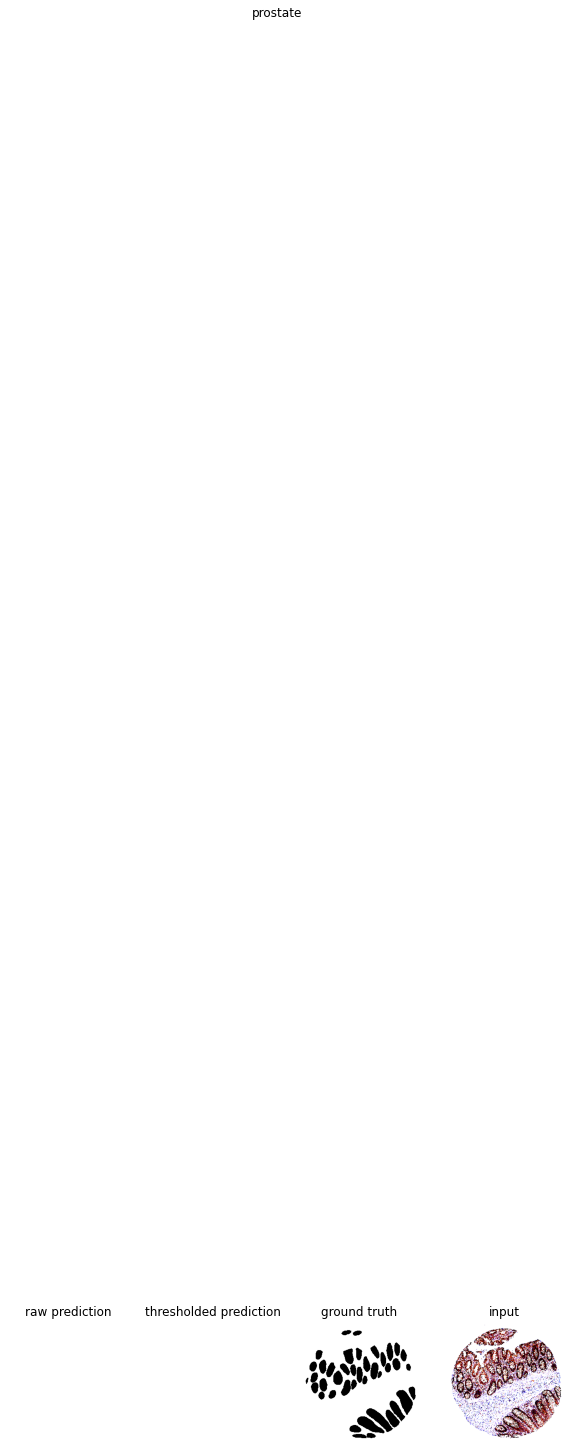

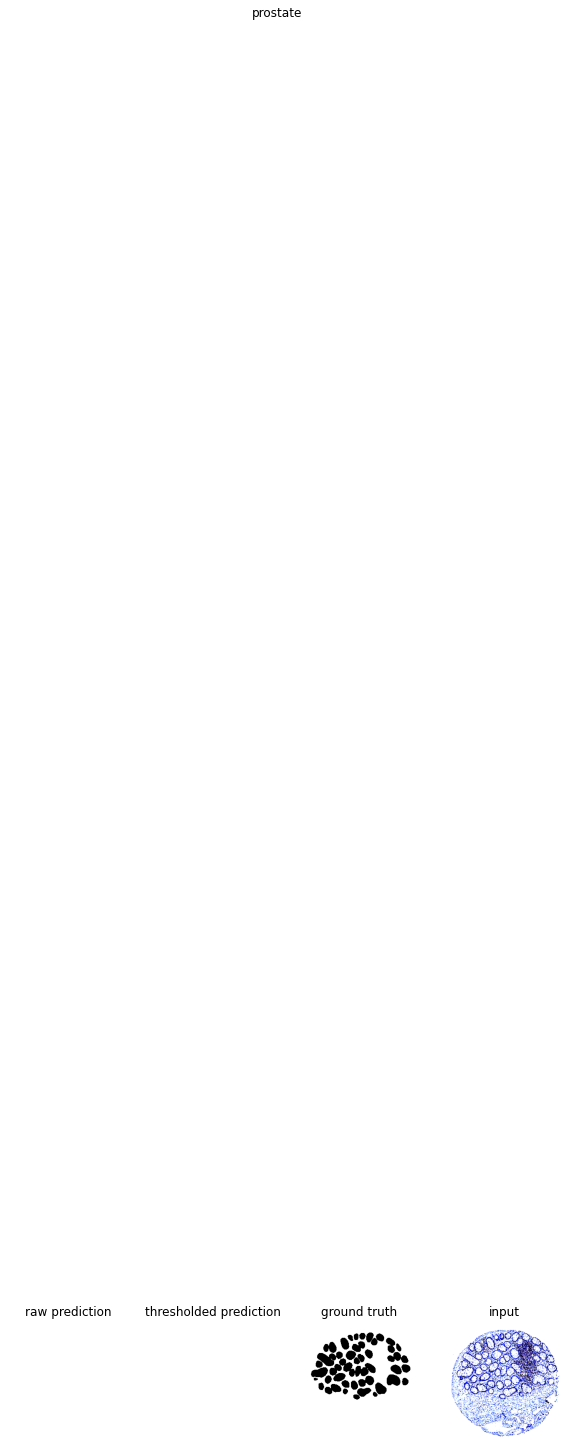

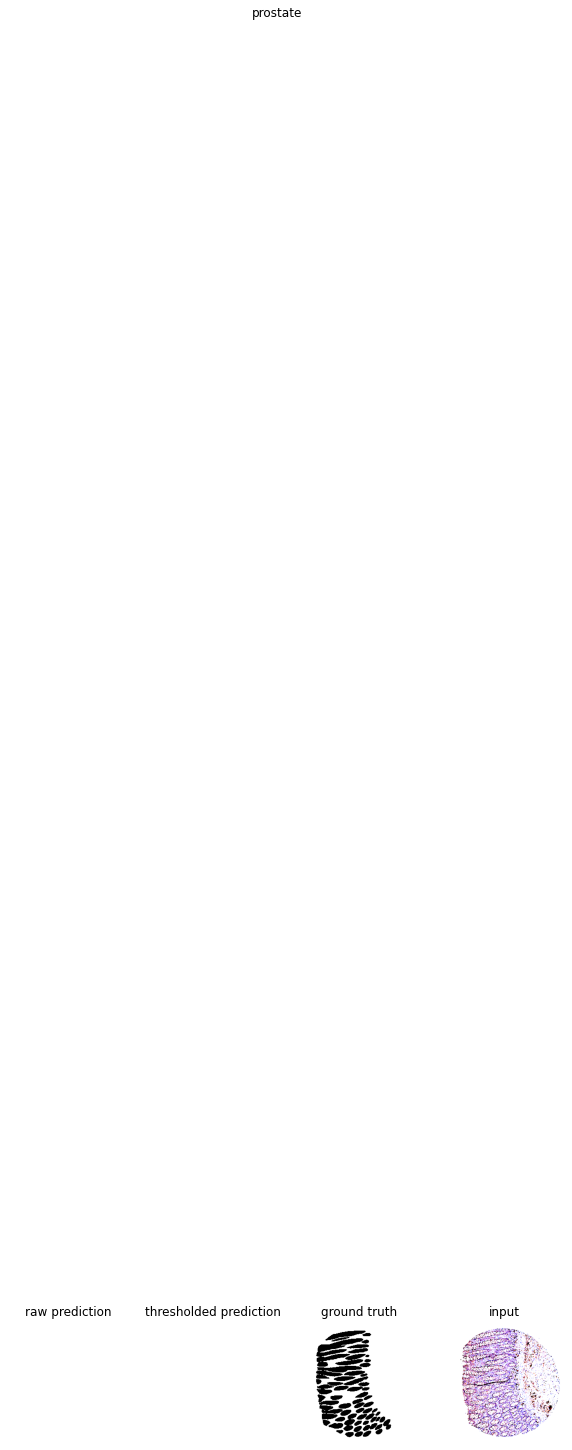

In [ ]:
model2 = Unet(16)
model2.load_state_dict(torch.load('/content/drive/MyDrive/BioimageProjData/biu_aug_deeper_prostate_dice_loss_new.pt'))
model2.to(device)
model2.eval()
# my_dice_coeffs_05=np.array([])
# my_dice_coeffs_03=np.array([])
# my_dice_coeffs_02=np.array([])
# my_dice_coeffs_01=np.array([])
count = 0
for inputs, labels in dataloaders_dict['val']:
  inputs = inputs.to(device)
  labels = labels.to(device)
  outputs = biu(inputs)
  # outputs = model2(inputs)
  # my_dice_coeffs_05 = np.append(my_dice_coeffs_05,my_dice(outputs, labels, 0.5).flatten())
  # my_dice_coeffs_03 = np.append(my_dice_coeffs_03,my_dice(outputs, labels, 0.3).flatten())
  # my_dice_coeffs_01 = np.append(my_dice_coeffs_01,my_dice(outputs, labels, 0.1).flatten())
  # my_dice_coeffs_02 = np.append(my_dice_coeffs_02,my_dice(outputs, labels, 0.2).flatten())
  # print(outputs[0,0,:,:])
  # break
  plt.figure(count)
  fig, ax = plt.subplots(1,4,figsize=(10,40))
  
  sample_outputs = outputs[0,0,:,:].cpu().detach().numpy()
  ax[0].imshow(sample_outputs, cmap='Greys')
  ax[0].axis('off')
  ax[0].title.set_text('raw prediction')
  # plt.figure(1)
  ax[1].imshow(sample_outputs>0.3, cmap='Greys')
  ax[1].axis('off')
  ax[1].title.set_text('thresholded prediction')
  # plt.figure(2)
  # plt.imshow(outputs[0,0,:,:].cpu().detach().numpy()>0.5, cmap='Greys')
  # plt.figure(3)
  # plt.imshow(outputs[0,0,:,:].cpu().detach().numpy()>0.1, cmap='Greys')
  # plt.figure(4)
  ax[2].imshow(labels[0,0,:,:].cpu().detach().numpy(), cmap='Greys')
  ax[2].axis('off')
  ax[2].title.set_text('ground truth')
  ax[3].imshow(np.flipud(np.rot90(inputs[0,:,:,:].cpu().detach().numpy().T)))
  ax[3].axis('off')
  ax[3].title.set_text('input')
  fig.suptitle('prostate')
  # print(dice_loss(outputs, labels))
  # break
  
  count += 1



In [ ]:
# print('0.1', np.mean(np.array(my_dice_coeffs_01)))
# print('0.2', np.mean(np.array(my_dice_coeffs_02)))
# print('0.3', np.mean(np.array(my_dice_coeffs_03)))
# print('0.5', np.mean(np.array(my_dice_coeffs_05)))

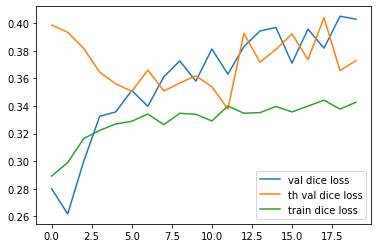

In [ ]:
val_dice_l = []
for loss in val_dice_loss_hist:
  val_dice_l.append(loss.item())
plt.plot(np.array(val_loss_hist))
plt.plot(np.array(val_dice_l))
plt.plot(np.array(train_loss_hist))
plt.legend(['val dice loss', 'th val dice loss', 'train dice loss'])#
plt.show()